In [2]:
import numpy as np
import pandas as pd
import requests
from lxml import html
from bs4 import BeautifulSoup
import re
import matplotlib.pyplot as plt
import time
import pickle
import seaborn as sns
import statsmodels.api as sm
from IPython.core.debugger import set_trace

import praw
from psaw import PushshiftAPI
import datetime

In [15]:
def get_web_content(addr, ret = 'html'):
    """
    Gets content from a webpage and returns BSoup object or html object or both
    
    Parameters
    ----------
    addr: str
        webpage address
    ret: str, optional
        tag that decides what object the function returns.
        if 'html' function returns html object, 'soup' function returns BSoup object
        'htmlsoup' returns both objects
        Default = 'html'
    
    Returns
    -------
    BSoup object
        if ret tag is 'soup'
    html object
        if ret tag is 'html'
    tuple of (html object, BSoup object)
        if ret tag is 'htmlsoup'
        
    Notes
    -----
    [None]

    """
    try:
        pageContent = requests.get(addr) 
    except:
        print('Webpage inaccessible, please correct webpage address')
        
    if ret == 'html':
        return html.fromstring(pageContent.content)
    elif ret == 'soup':
        return BeautifulSoup(pageContent.text, 'html.parser')
    elif ret == 'htmlsoup':
        return (html.fromstring(pageContent.content),BeautifulSoup(pageContent.text, 'html.parser'))
    else:
        print('Error: ret tag is invalid in get_web_content')
        return None

        
def get_table_row(tree, xpath, counter):
    """
    Returns the output of html.xpath(xpath address) given an xpath address.
    
    Parameters
    ----------
    tree: lxml.html object  
        the object returned by the html function of the lxml module.
        Generally used with requests package. 
    xpath: str with placeholder
        the xpath address to pull data from. Requires a placeholder to specify a div tag
        example: '/head/div[{}].'
    counter: int
        specifies the tag in the xpath address
        
    Returns
    -------
    tree.xpath(xpath.format(counter))
    
    Raises
    ------
    Error (str): if tree.xpath(xpath.format(counter)) cannot return an object
        
    Notes
    -----
    This function is specifically used to pull rows from a WikiTable
    """
    try:
        return tree.xpath(xpath.format(counter))
    except:
        print('Error: Cannot extract table rows, check Xpath path and/or row index where content starts (int(counter))')
    

def get_cleaned_row(html_text):
    """
    Returns cleaned values from a row of a wiki table
    
    Parameters
    ----------
    html_text: str  
        text extracted from the html script of a row of a wiki table 
    Returns
    -------
    List
        A list of the first 7 values extracted from the row of a wiki table
        
    Notes
    -----
    This function is specifically used to pull values from rows of a specific WikiTable
    """    
    cleaned_html_text=[]
    
    for i in range(len(html_text)-1):
        if html_text[i] != '\n' and html_text[i+1] != '\n':
            j = 1
            while html_text[i+j] != '\n':
                html_text[i] = html_text[i] + html_text[i+j]
                html_text[i+j] = '\n'
                j += 1

    for elem in html_text:
        if elem != '\n':
            cleaned_html_text.append(elem.replace('\n',''))
    
    return cleaned_html_text[0:7]
    

def get_wiki_table_list(addr, xpath, counter, assembled_list = None):
    """
    Returns a list of list containing the first 7 values from each row of a Wikitable
    
    Parameters
    ----------
    addr: str
        webpage address
    xpath: str with placeholder
        the xpath address to pull data from. Requires a placeholder to specify a div tag
        example: '/head/div[{}].'
    counter: int
        the starting point of the xpath address. Used to skip the headers of a WikiTable
    assembled_list: list of lists, optional
        the output of get_wiki_table_list. Can be used to aggregate data from multiple tables in a recursive way.
        Default = None
    Returns
    -------
    List of lists
        A list of the first 7 values extracted from the row of a wiki table
        
    Notes
    -----
    This function is specifically used to pull values from rows of a specific WikiTable
    """ 
    tree = get_web_content(addr,'html')
    html_text = get_table_row(tree, xpath, counter)
    
    if not assembled_list:
        assembled_list = []
    
    while html_text:
        assembled_list.append(get_cleaned_row(html_text))
        counter += 1
        html_text = get_table_row(tree, xpath, counter)
        
    return assembled_list  

def get_wiki_table_df(full_list,
                     columns=['Titles','Genres','Developers','Publishers','ReleaseDate_JP','ReleaseDate_EU','ReleaseDate_NA']):
    """
    Returns a dataframe from a given list of lists, given 7 column data. 
    The last three columns are converted to datetime format.
    
    Parameters
    ----------
    full_list: List of lists  
    
    columns: List of str, optional
        This will be used to create the column headers of the dataframe.
        The last three columns 
        Default ['Titles','Genres','Developers','Publishers','ReleaseDate_JP','ReleaseDate_EU','ReleaseDate_NA']
        
    Returns
    -------
    Pandas.DataFrame object
    
    Raises
    ------
    Error (str): if issues with list of list commonly from scraping issues
    Error (str): if issues with datetime conversion
    
    Notes
    -----
    This function is specifically used to convert a specific WikiTable scraped data into a dataframe.
    """    
    
    try:
        ps4_game_list = pd.DataFrame(full_list, columns = columns)
    except:
        print('Error: issues with converting scraped wiki table data into DataFrame.')
        return None
    
    release_list = [columns[4],columns[5],columns[6]]

    for col in release_list:
        try:
            ps4_game_list[col]=pd.to_datetime(ps4_game_list[col],infer_datetime_format=True,errors='coerce')
        except:
            print('Could not convert scraped release date columns into datetime format.')

    punc_dict={ord('\''):None, ord(':'):None, ord('#'):None, ord('/'):' ', 
           ord('&'):None, ord(';'):' ', ord('!'):None, ord(','):None, ord('?'):None, ord('.'):None}        
    
    ps4_game_list['TitlesHTML'] = ps4_game_list['Titles'].str.replace('\.0',' 0').str.replace('\.1',' 1').str.replace('\.5',' 5').str.replace(' -',' ').str.replace('//',' ').str.translate(punc_dict).str.replace('  ',' ').str.strip().str.lower().str.replace(' ','+')
    
    return ps4_game_list


In [48]:
def find_pricing_script(script_tag):
    """
    Returns the right script tag from a given html text
    
    Parameters
    ----------
    script_tag: str
        html text returned extracted from a BSoup object 
        
    Returns
    -------
    Pandas.DataFrame object
    
    Raises
    ------
    Error (str): if issues with list of list commonly from scraping issues
    Error (str): if issues with datetime conversion
    
    Notes
    -----
    This function is specifically used to convert a specific WikiTable scraped data into a dataframe.
    """
    find = False
    counter = -1
    while not find:
        counter += 1
        try:
            script_text = script_tag[counter].text
        except:
            print('Could not find script with the price history, check web address.')
            
        if 'Price, USD' in script_text:
            find = True
            
    return script_text

def find_reg(reg_str,content):
    """
    Extracts data using a RegEx string
    
    Parameters
    ----------
    reg_str: str
        RegEx string
        
    content: str
        text on which the regex extract needs to take place
        
    Returns
    -------
    re.findall(reg_str,content): List of Lists of str, or List of str
        return type can change depending on RegEx string
    
    Raises
    ------
    Error (str): if no text is extracted
    
    Notes
    -----
    This function is specifically used to extract the price and date from the pricing history HTML script tag text.
    """
    reg_find = re.findall(reg_str,content)
    assert reg_find is not None, "Could not extract any content, check regex string"
    return reg_find

    
def get_reg_output(soup, reg_string):
    """
    Accepts a soup object, finds the right script tag with pricing details and returns the dates and price history using the find_reg function.
    
    Parameters
    ----------
    soup: BSoup object
    
    reg_str: str
        RegEx string        
        
    Returns
    -------
    List of Lists of str, or List of str
        return type can change depending on RegEx string
    
    Notes
    -----
    This function is specifically used to extract the price and date from the pricing history HTML script tag text.
    """
    script_text = find_pricing_script(soup.find_all('script'))
    script_text_cut = script_text[0:script_text.find('PS+')]
    return find_reg(reg_string, script_text_cut)  

def convert_date_to_cumdays(series):
    """
    Converts an ordered datetime object to cumulative no. of days starting from 0.
    
    Parameters
    ----------
    series: Pandas.Series.datetime object
    
    Returns
    -------
    Pandas.Series of element type float
    
    """

    newseries = series.copy()
    newseries[0] = 0
    newseries.iloc[1:] = series.diff().iloc[1:].cumsum().dt.days
    return newseries.astype(float)

def convert_normlogprice(series):
    """
    Log transforms a Pandas series after normalizing it by dividing the series by the first element.
    
    Parameters
    ----------
    series: Pandas.Series object
    
    Returns
    -------
    Pandas.Series
    
    """
    return np.log(series.div(series[0]))
    
def convert_price_todataframe(reg_output):
    """
    Converts a List of lists of str into a DataFrame. First column is assumed to be a datetime col.
    Second column is assumed to be a float column. This conversion is automatically performed.
    Third column will be the cumulative number of days extracted from the datetime column.
    Fourth column is the normalized logtransform of the float column.
    
    Parameters
    ----------
    reg_output: List of lists of str
    
    Returns
    -------
    Pandas.DataFrame
    
    Notes
    -----
    Specifically used to convert the regex extraction of price history and dates into a DataFrame.
    
    """
    try:
        price_history = pd.DataFrame(reg_output, columns = ['Date','Price'])
    except:
        print('Could not convert scraped price history to dataframe. Check regex function.')
    try:
        price_history['Date'] = pd.to_datetime(price_history['Date'],infer_datetime_format=True,errors='coerce')
    except:
        print('Could not convert scraped price history dates into datetime format')
    try:
        price_history['Price'] = pd.to_numeric(price_history['Price'],errors='coerce')
    except:
        print('Could not convert scraped prices into float format.')
    
    price_history['NormLogPrice'] = convert_normlogprice(price_history['Price'])
    price_history['Days'] = convert_date_to_cumdays(price_history['Date'])
    return price_history

def get_review(tree, 
               xpath_adr ='/html/body/div[1]/div[2]/div[3]/div[1]/div[1]/div/div/div/div/a/text()'):
    """
    Extract specific text 
    
    Parameters
    ----------
    reg_output: List of lists of str
    
    Returns
    -------
    Pandas.DataFrame
    
    Notes
    -----
    Specifically used to convert the regex extraction of price history and dates into a DataFrame.
    
    """
    try:
        return float(tree.xpath(xpath_adr)[0])
    except:
        return np.nan

def get_price_historyandrev_psprices(addr, game_name = None, 
                               reg_string = r'\"x\"\:\s\"(\d{4}-\d{2}-\d{2})\"\,\s\"y\"\:\s(\d+\.\d+)'):
    """
    Get price histories (as a DataFrame) and reviews from PSprices.com for a certain game, given the right link.
    
    Parameters
    ----------
    addr: str
        Website link for the game
    
    game_name: str, optional
        The name of the game to look for. 
        Only needed if there's a possibility that the website link might go into the search page instead of the game page.
        Default None
        
    reg_string: str, optional
        The regex string to extract date and prices
        Default r'\"x\"\:\s\"(\d{4}-\d{2}-\d{2})\"\,\s\"y\"\:\s(\d+\.\d+)'
    
    Returns
    -------
    Tuple of (Pandas.DataFrame, Bool, Float)
        DataFrame consists of price history, dates, and other derivatives
        Bool provides an indicator if the data was successfully scraped or not
        Float is the value of review which may be NaN if it cannot be scraped
        If the price history cannot be extracted, will return (None, False, NaN)
    
    Notes
    -----
    Specifically used to extract price history and dates and reviews from Psprices.com
    
    """
    (tree, soup) = get_web_content(addr,'htmlsoup')
    pusd = 'Price, USD' in soup.text
    sres = 'search results' in soup.text
    nfnd = 'Sorry, nothing found' in soup.text
    
    if pusd:
        reg_output = get_reg_output(soup,reg_string)
        rev_val = get_review(tree)
        return (convert_price_todataframe(reg_output),True, rev_val)
    elif sres and not nfnd:
        new_addr = get_price_history_link(tree, game_name)
        if new_addr is not None:
            (tree_new, soup_new) = get_web_content(new_addr,'htmlsoup')
            reg_output = get_reg_output(soup_new,reg_string)
            rev_val = get_review(tree_new)
            return (convert_price_todataframe(reg_output),True, rev_val)
        else:
            return (None,False,np.nan)
    else:
        return (None,False,np.nan)
    
    
def get_price_history_link(tree, game_name,
                           search_hits  = '/html/body/div[1]/div[2]/div/div/a/span/span/text()',
                           search_links = '/html/body/div[1]/div[2]/div/div/a/@href', 
                           addon = 'https://psprices.com'):

    """
    Get the link to a the website of the target video game assuming the landing page is the search page.
    
    Parameters
    ----------
    tree: lxml.html object
        Object containing html that can be extracted using Xpath or CSS Locators
    
    game_name: str
        The name of the game to look for. 

    search_hits: str, optional
        The Xpath address to extract all the games present on the search landing page
        Default  '/html/body/div[1]/div[2]/div/div/a/span/span/text()'
        
    search_links: str, optional
        The Xpath address to extract all the links for the games present on the search landing page
        Default  '/html/body/div[1]/div[2]/div/div/a/@href'

    addon: str, optional
        The main website address which will be appended to the game link extracted by the scraping algorithm to create a complete web link.
        Default 'https://psprices.com'
    
    Returns
    -------
    Str
        Website link for the game. Returns None if game is not found.
    
    """
    
    punc_dict={ord('\''):None, ord(':'):None, ord('#'):None, ord('~'):None, 
               ord('('):None, ord(')'):None, ord('—'):None, ord('/'):' ', 
           ord('&'):None, ord(';'):' ', ord('!'):None, ord(','):None, ord('?'):None, ord('.'):None}  
    
    game_name = game_name.lower().translate(punc_dict).replace('  ',' ').replace('  ',' ')
    
    game_link_dict = {key.lower().translate(punc_dict).replace('  ',' ').replace('  ',' '):value 
                      for key, value in zip(tree.xpath(search_hits),tree.xpath(search_links))}
    
    if game_name in game_link_dict.keys():
        try:
            return addon + game_link_dict[game_name]
        except:
            print(f"Did not find {game_name} in search results. Returning None")
            return None
    elif game_name+' standard edition' in game_link_dict.keys():
        try:
            return addon + game_link_dict[game_name+' standard edition']
        except:
            print(f"Did not find {game_name} in search results. Returning None")
            return None
    elif game_name+' gold edition' in game_link_dict.keys():
        try:
            return addon + game_link_dict[game_name+' gold edition']
        except:
            print(f"Did not find {game_name} in search results. Returning None")
            return None
    elif game_name+' deluxe edition' in game_link_dict.keys():
        try:
            return addon + game_link_dict[game_name+' deluxe edition']
        except:
            print(f"Did not find {game_name} in search results. Returning None")
            return None
    elif game_name+' ps4' in game_link_dict.keys():
        try:
            return addon + game_link_dict[game_name+' ps4']
        except:
            print(f"Did not find {game_name} in search results. Returning None")
            return None
    elif game_name+' playstation 4 edition' in game_link_dict.keys():
        try:
            return addon + game_link_dict[game_name+' playstation 4 edition']
        except:
            print(f"Did not find {game_name} in search results. Returning None")
            return None      
    elif game_name+' enhanced edition' in game_link_dict.keys():
        try:
            return addon + game_link_dict[game_name+' enhanced edition']
        except:
            print(f"Did not find {game_name} in search results. Returning None")
            return None
    elif game_name+' game of the year edition' in game_link_dict.keys():
        try:
            return addon + game_link_dict[game_name+' game of the year edition']
        except:
            print(f"Did not find {game_name} in search results. Returning None")
            return None
    else:
        return None  


def get_all_price_histsandrev(df, col_name = 'TitlesHTML', 
                              sleep_sec = 1, 
                              pshist_link = 'https://psprices.com/region-us/search/?q={}&platform=PS4&dlc=hide'):
    """
    Get price histories (as a DataFrame) and reviews from PSprices.com for a dataframe that includes a list of game search titles
    
    Parameters
    ----------
    df: Pandas.DataFrame
        DataFrame that contains a list of HTML ready search keywords for certain games
    
    col_name: str, optional
        The name of the column that contains HTML ready search keywords for certain games
        Default 'TitlesHTML'
        
    sleep_sec: int, optional
        Amount of time in seconds to sleep between request calls from website
        Default 1
        
    pshist_link: str, optional
        A website link with a placeholder to fit keywords and then search on the website
        Default 'https://psprices.com/region-us/search/?q={}&platform=PS4&dlc=hide'
    
    Returns
    -------
    Dict
        game_name:{pricehistory-date dataframe} as key:value pairs.
    
    Pandas.DataFrame (Shadow)
        Additional columns added to df 
    
    Notes
    -----
    Make a copy of dataframe df if you do not want the original to be modified.
    """    
    game_price_dict ={}
    link_obt = []
    rev_obt = [] 
    links = df[col_name].apply(lambda x: pshist_link.format(x))
    df['SearchLinks'] = links
    
    for title, link in zip(df['Titles'], links):
        (game_price_dict[title], link_tf, rev_val) = get_price_historyandrev_psprices(link,game_name=title)
        link_obt.append(link_tf)
        rev_obt.append(rev_val)
        print(f"Price history for game: {title} was found: {link_tf}")
        time.sleep(sleep_sec)
    
    df['HistScrapped'] = link_obt
    df['Reviews'] = rev_obt
    return game_price_dict


def price_pointplot(df, title, x_col = 'Days',y_col = 'Price'):
    """
    Plot Seaborn pointplots 
    
    Parameters
    ----------
    df: Pandas.DataFrame
    
    title: str
        Plot title
        
    x_col: str, optional
        name of the column in df that will be used as the X-axis
        Default 'Days'

    y_col: str, optional
        name of the column in df that will be used as the Y-axis
        Default 'Price'

    Returns
    -------
    None
    
    """    
    sns.set(color_codes=True, rc={"font.size":18,"axes.titlesize":18,"axes.labelsize":18})
    lm = sns.pointplot(x=x_col, y=y_col, data = df, height=6.27, aspect=11.7/8.27)
    lm.axes.set_ylim(0,65)
    plt.setp(lm.get_xticklabels(), rotation=90)
    plt.title(title)

def logprice_regplot(df, title,  slope, intercept, x_col = 'Days', 
                     y_col = 'NormLogPrice', ylim=(-3,1), 
                     days = None, plotreg = False):
    """
    Plot Seaborn lmplot with linear regressions and confidence intervals.
    Also overlay plots slope*X + intercept to check the validity of regression coefficients.  
    
    Parameters
    ----------
    df: Pandas.DataFrame
    
    title: str
        Plot title
        
    slope: Float
        value of slope in slope*X + intercept

    intercept: Float
        value of intercept in slope*X + intercept

    x_col: str, optional
        name of the column in df that will be used as the X-axis
        Default 'Days'

    y_col: str, optional
        name of the column in df that will be used as the Y-axis
        Default 'NormLogPrice'
        
    ylim: tuple, optional
        ylimits for seaborn plot 
        Default (-3,1)
        
    days: int, optional
        Limit the regressions to a certain amount of days
        Default None
        
    plotreg: bool, optional
        Plots overlays of slope*X + intercept
        Default False

    Returns
    -------
    None
    
    """ 
    sns.set(color_codes=True, rc={"font.size":18,"axes.titlesize":18,"axes.labelsize":18})
    if days is not None:
        df_lim = df[df['Days']<=days].copy()
    lm = sns.lmplot(x=x_col, y=y_col, data = df_lim,height=6.27, aspect=11.7/8.27)
    if days is not None:
        lm.axes[0,0].set_xlim(0,days)
    lm.axes[0,0].set_ylim(ylim)
    plt.title(title)
    if plotreg:
        plt.plot(df_lim['Days'],slope*df_lim['Days']+intercept,'k*')

def logprice_reg_params(df_lim, x_col = 'Days', y_col = 'NormLogPrice', days = None, reg_model = False):
    
    if days is not None:
        df = df_lim[df_lim['Days']<=days].copy()
    else:
        df = df_lim
        
    reg_X = df[x_col].values
    reg_X = sm.add_constant(reg_X)
    model = sm.OLS(df[y_col].values, reg_X).fit() 
    
    if np.inf in np.abs(model.params):
        if reg_model:
            return([np.nan,np.nan],None)
        else:
            return([np.nan,np.nan])
    
    if reg_model:
        return (model.params, model)
    else:
        return model.params

def get_prepdf_withreg(df,game_price_dict, days = None, 
                       publisher_medval = 18, publisher_lowval = 3,
                      dev_medval = 4, dev_lowval = 1, genre_map = 'genre.csv'):

    df['LogRegSlope'] = np.nan
    df['LogRegIntcpt'] = np.nan
    df['InitPrice'] = np.nan

    suc_df = df[df['Reviews'].notnull()]
    slope = []
    intercept = []
    init_price = []
    
    for title in suc_df['Titles']:
        sl_int = logprice_reg_params(game_price_dict[title],x_col = 'Days', 
                                     y_col = 'NormLogPrice', days = days, reg_model=False)
        slope.append(sl_int[1])
        intercept.append(sl_int[0])
        init_price.append(game_price_dict[title]['Price'][0])

    df['LogRegSlope'] = pd.DataFrame(slope,index=suc_df.index,columns=['LogRegSlope'])
    df['LogRegIntcpt'] = pd.DataFrame(intercept,index=suc_df.index,columns=['LogRegIntcpt'])
    df['InitPrice'] = pd.DataFrame(init_price,index=suc_df.index,columns=['InitPrice'])
    
    convert_genres(df, genre_map)
    convert_catstrength(df,'Publishers',publisher_medval,publisher_lowval)
    convert_catstrength(df,'Developers',dev_medval,dev_lowval)
    
    df['ReleaseDate_Agg'] = np.where(df['ReleaseDate_NA'].isna(),df['ReleaseDate_EU'],df['ReleaseDate_NA'])
    df['ReleaseDate_Agg'] = np.where(df['ReleaseDate_Agg'].isna(),df['ReleaseDate_JP'],df['ReleaseDate_Agg'])
    df['ReleaseDate_Agg'] = pd.to_datetime(df['ReleaseDate_Agg'],infer_datetime_format=True,errors='coerce')
    df['Release_Year'] = ps4_game_list['ReleaseDate_Agg'].dt.year
    df['Release_Month'] = ps4_game_list['ReleaseDate_Agg'].dt.month
    df['Release_Day'] = ps4_game_list['ReleaseDate_Agg'].dt.day

    
def get_successcol(df,col='LogRegSlope',threshold = -0.0001,verbose=False):   
    df['Success'] = np.where(df[col] > threshold, 0,1)
    if verbose:
        print(df['Success'][df[col].notna()].value_counts())
        
    
def convert_genres(df, genre_map):
    genre_transfrm = pd.read_csv(genre_map)
    genre = {}
    for row_label,  row_array_Series   in genre_transfrm.iterrows():
        genre[row_array_Series['Old']] = row_array_Series['New']

    df['MappedGenres'] = df['Genres'].map(genre)
    try:
        assert df['MappedGenres'].notna().all()
    except:
        print("WARNING: The Genre CSV needs to be updated")

def convert_catstrength(df,col_name,med_val,low_val):
    val_cts = df[col_name].value_counts()
    val_dict = {}
    
    for name in val_cts[val_cts > med_val].index:
        val_dict[name] = 'High'+ col_name
        
    for name in val_cts[(val_cts <= med_val) & (val_cts > low_val)].index:
        val_dict[name] = 'Med'+ col_name

    for name in val_cts[val_cts <= low_val].index:
        val_dict[name] = 'Low'+ col_name
    
    new_col_name = 'Mapped{}'.format(col_name)
    
    df[new_col_name] = df[col_name].map(val_dict)
        

In [109]:
xpath_0_m = '/html/body/div[3]/div[3]/div[4]/div/table[2]//tr[{}]//text()'
html_add_0_m = 'https://en.wikipedia.org/wiki/List_of_PlayStation_4_games'

xpath_m_z = '/html/body/div[3]/div[3]/div[4]/div/table/tbody/tr[{}]//text()'
html_add_m_z = 'https://en.wikipedia.org/wiki/List_of_PlayStation_4_games_(M-Z)'

ps4_game_list = get_wiki_table_df(    
    get_wiki_table_list(html_add_m_z, xpath_m_z, 3, get_wiki_table_list(html_add_0_m, xpath_0_m, 3)))


#------------------------TEMP WORKAROUND
ps4_game_list_cp = pd.read_csv('ps4_game_list_predicted.csv',index_col = 0)
ps4_game_list['Reviews'] = np.nan
ps4_game_list.loc[ps4_game_list_cp.index,['Reviews']] = ps4_game_list_cp['Reviews']
ps4_game_list.loc[ps4_game_list_cp.index,['Titles']] = ps4_game_list_cp['Titles']


#--------------------- ACTIVATE WHEN ACTUALLY SCRAPING
#ps4_game_pricehist_dict = {}
#ps4_game_pricehist_dict = get_all_price_histsandrev(ps4_game_list)
#-------------WARNING BE VERY CAREFUL BEFORE ACTIVATING BELOW
#pickle.dump(ps4_game_pricehist_dict, open('pricehist_pkl.sav', 'wb'))


get_prepdf_withreg(ps4_game_list,ps4_game_pricehist_dict, days = None, 
                       publisher_medval = 18, publisher_lowval = 3,
                      dev_medval = 4, dev_lowval = 1, genre_map = 'genre.csv')

get_successcol(ps4_game_list,threshold = -0.0003, verbose=True)

ps4_game_list.to_csv('ps4_game_list.csv')

psaw_api = create_psaw_instance(create_reddit_instance(filename = 'RedditAuth'))
prepdf_for_comments(ps4_game_list,comment_window = 30)

df = ps4_game_list[ps4_game_list['Reviews'].notna()].dropna().reset_index().drop(['index'],axis=1)
get_reddit_comments(df,psaw_api,max_response_cache = 100)



1    421
0    364
Name: Success, dtype: int64


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


Game: 11-11+memories+retold, comment length: 35510
Game: 1001+spikes, comment length: 35695
Game: 2064+read+only+memories, comment length: 47544
Game: 20xx+PS4, comment length: 24430
Game: the+25th+ward+the+silver+case, comment length: 30159
Game: 2dark+PS4, comment length: 11950
Game: 428+shibuya+scramble, comment length: 31399
Game: 88+heroes, comment length: 157312
Game: aaero+PS4, comment length: 2279
Game: absolver, comment length: 22395
Game: action+henk, comment length: 37813
Game: aegis+defenders, comment length: 58864
Game: aegis+of+earth+protonovus+assault, comment length: 69693
Game: aer+memories+of+old, comment length: 16442
Game: agatha+christie+the+abc+murders, comment length: 42519
Game: agents+of+mayhem, comment length: 20716
Game: akibas+beat, comment length: 8254
Game: akibas+trip+undead+undressed, comment length: 931
Game: alekhines+gun, comment length: 5568
Game: alienation, comment length: 42177
Game: alien+isolation, comment length: 30735
Game: angerforce+reloaded

Game: demon+gaze+ii, comment length: 75651
Game: detroit+become+human, comment length: 30005
Game: deus+ex+mankind+divided, comment length: 32707
Game: devil+may+cry+hd+collection, comment length: 75039
Game: devil+may+cry+4+special+edition, comment length: 80061
Game: devious+dungeon+2, comment length: 47297
Game: digimon+story+cyber+sleuth, comment length: 41443
Game: digimon+story+cyber+sleuth+–+hackers+memory, comment length: 9831
Game: digimon+world+next+order, comment length: 53753
Game: dirt+4, comment length: 54382
Game: disgaea+1+complete, comment length: 107441
Game: disgaea+5+complete, comment length: 93352
Game: dishonored+definitive+edition, comment length: 52297
Game: dishonored+2, comment length: 28944
Game: dishonored+death+of+the+outsider, comment length: 34418
Game: dissidia+final+fantasy+nt, comment length: 71553
Game: divinity+original+sin, comment length: 21502
Game: divinity+original+sin+ii, comment length: 26547
Game: djmax+respect, comment length: 35781
Game: do

Game: the+inner+world, comment length: 120687
Game: the+inpatient, comment length: 60230
Game: inside, comment length: 36292
Game: jojos+bizarre+adventure+eyes+of+heaven, comment length: 1199
Game: jotun+valhalla+edition, comment length: 48541
Game: journey, comment length: 38291
Game: jurassic+world+evolution, comment length: 20465
Game: just+cause+3, comment length: 78806
Game: keep+talking+and+nobody+explodes, comment length: 31040
Game: ken+folletts+the+pillars+of+the+earth, comment length: 0
Game: kero+blaster, comment length: 34010
Game: kholat, comment length: 27946
Game: kill+la+kill+if, comment length: 115892
Game: killzone+shadow+fall, comment length: 30937
Game: the+king+of+fighters+xiv, comment length: 85556
Game: kingdom+come+deliverance, comment length: 18389
Game: kingdom+new+lands, comment length: 37860
Game: kingdom+two+crowns, comment length: 41990
Game: knack+PS4, comment length: 35830
Game: knack+2, comment length: 21145
Game: labyrinth+of+refrain+coven+of+dusk, com

Game: patapon+remastered, comment length: 42525
Game: perfect+universe, comment length: 89679
Game: persona+5, comment length: 22316
Game: pic-a-pix+pieces, comment length: 0
Game: pier+solar+and+the+great+architects, comment length: 41458
Game: pixark, comment length: 19138
Game: pix+the+cat, comment length: 75092
Game: pixeljunk+monsters+2, comment length: 54461
Game: plague+inc+evolved, comment length: 28372
Game: planet+of+the+apes+last+frontier, comment length: 3605
Game: plants+vs+zombies+garden+warfare+2, comment length: 44782
Game: playerunknowns+battlegrounds, comment length: 16444
Game: pneuma+breath+of+life, comment length: 48325
Game: portal+knights, comment length: 24089
Game: power+rangers+battle+for+the+grid, comment length: 34127
Game: prey+PS4, comment length: 67847
Game: project+cars, comment length: 32664
Game: project+cars+2, comment length: 32917
Game: psycho-pass+mandatory+happiness, comment length: 71749
Game: push+me+pull+you, comment length: 160568
Game: puyo+p

Game: tom+clancys+rainbow+six+siege, comment length: 20849
Game: tom+clancys+the+division, comment length: 20894
Game: tom+clancys+the+division+2, comment length: 15025
Game: torment+tides+of+numenera, comment length: 35965
Game: touhou+kobuto+v+burst+battle, comment length: 26765
Game: toukiden+2, comment length: 75290
Game: toukiden+kiwami, comment length: 52307
Game: tower+of+guns, comment length: 95767
Game: towerfall+ascension, comment length: 28631
Game: the+town+of+light, comment length: 156919
Game: trackmania+turbo, comment length: 25216
Game: transistor, comment length: 26216
Game: travis+strikes+again+no+more+heroes, comment length: 38474
Game: trials+fusion, comment length: 24246
Game: trials+of+the+blood+dragon, comment length: 83311
Game: tricky+towers, comment length: 26644
Game: trine+2+complete+story, comment length: 109422
Game: tropico+5, comment length: 48240
Game: tropico+6, comment length: 35489
Game: trüberbrook, comment length: 3171
Game: tt+isle+of+man+ride+on+

In [4]:
df = pd.read_csv('revsandtext.csv', index_col = 0)
df_all = df[['Reviews', 'InitPrice',
       'MappedGenres', 'MappedPublishers', 'MappedDevelopers',
                    'Release_Year', 'Release_Month', 'Release_Day',
       'Game_comments','Success']]
df.head()


,Titles,Genres,Developers,Publishers,ReleaseDate_JP,ReleaseDate_EU,ReleaseDate_NA,TitlesHTML,Reviews,LogRegSlope,...,MappedGenres,MappedPublishers,MappedDevelopers,ReleaseDate_Agg,Release_Year,Release_Month,Release_Day,Success,CommentWindow,Game_comments
0,11-11: Memories Retold,Adventure,AardmanDigixArt,Bandai Namco Entertainment,2018-11-09,2018-11-09,2018-11-09,11-11+memories+retold,77.0,-0.002215,...,Adventure,HighPublishers,LowDevelopers,2018-11-09,2018.0,11.0,9.0,1,2018-10-10,Well some suggestions from me would be Nier Au...
1,1001 Spikes,Platform,8bits Fanatics,Nicalis,2015-11-27,2015-10-07,2014-06-03,1001+spikes,79.0,0.000000,...,Platformer,MedPublishers,LowDevelopers,2014-06-03,2014.0,6.0,3.0,0,2014-05-04,Its hard for me to compare difficulty of games...
2,2064: Read Only Memories,Adventure,MidBoss,MidBoss,2017-01-17,2017-01-17,2017-01-17,2064+read+only+memories,79.0,-0.000232,...,Adventure,LowPublishers,LowDevelopers,2017-01-17,2017.0,1.0,17.0,0,2016-12-18,Nothing spectacular but a couple fun ones to ...
3,20XX,Actionplatform,Batterystaple Games,Batterystaple Games,2018-07-10,2018-07-10,2018-07-10,20xx+PS4,79.0,-0.000293,...,Action,LowPublishers,LowDevelopers,2018-07-10,2018.0,7.0,10.0,0,2018-06-10,PC Haydee Dust An Elysian Tail RWBY Grimm...
4,The 25th Ward: The Silver Case,Visual novel,Grasshopper Manufacture,NIS America,2018-03-15,2018-03-13,2018-03-13,the+25th+ward+the+silver+case,66.0,-0.000329,...,Adventure,MedPublishers,MedDevelopers,2018-03-13,2018.0,3.0,13.0,1,2018-02-11,Ok heres a list of stuff noone but me and 3 ot...


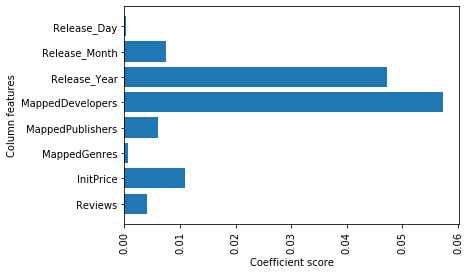


Analysis for : logreg
The best parameters for: logreg are :{'logreg__C': 1.2}
   mean_test_score              params
0         0.697452  {'logreg__C': 0.8}
1         0.700637    {'logreg__C': 1}
2         0.702229  {'logreg__C': 1.2}
3         0.702229  {'logreg__C': 1.4}
The score for logreg is 0.6687898089171974

Analysis for : knnstep
The best parameters for: knnstep are :{'knnstep__n_neighbors': 10}
    mean_test_score                        params
0          0.598726   {'knnstep__n_neighbors': 3}
1          0.608280   {'knnstep__n_neighbors': 4}
2          0.611465   {'knnstep__n_neighbors': 5}
3          0.619427   {'knnstep__n_neighbors': 6}
4          0.606688   {'knnstep__n_neighbors': 7}
5          0.619427   {'knnstep__n_neighbors': 8}
6          0.617834   {'knnstep__n_neighbors': 9}
7          0.635350  {'knnstep__n_neighbors': 10}
8          0.614650  {'knnstep__n_neighbors': 11}
9          0.625796  {'knnstep__n_neighbors': 12}
10         0.616242  {'knnstep__n_neighbor

In [111]:
#df_all = df[['Reviews', 'InitPrice',
#       'MappedGenres', 'MappedPublishers', 'MappedDevelopers',
#                    'Release_Year', 'Release_Month', 'Release_Day',
#       'Game_comments','Success']]


#df_all = pd.read_csv('../dat/cc_approvals_text.csv',na_values='?')
#df_all = df_all.drop(['Tweet'],axis=1)

x_train, x_test, y_train, y_test = preprocess_block(df_all, text_col='Game_comments', cat_var_limit=10, bin_rep=1,
                     max_tfidf_features=50, ngram_range=(1,2),
                     use_feat_select=True, 
                     alpha_space=np.linspace(0.01,0.02,20), 
                     random_state_var=20, test_size_var=.2)

_ = shallow_model(x_train, x_test, y_train, y_test)

_ = deep_model(x_train, x_test, y_train, y_test)

clf_shallow = load_model(clf='logreg')

clf_deep    = load_model('deep','Trained_deep_model.h5')

print(clf_shallow.predict(x_test))
print(clf_deep.predict(x_test))


In [ ]:
#test1 = a[a['MappedPublishers'] == 'LowPublishers']
d = []
b = []
for val in np.arange(500,650,5):
    get_prepdf_withreg(a,ps4_game_pricehist_dict,val)
    test1 = a
    plt.plot(test1['Reviews'],test1['LogRegSlope'],'k.')
    
    d.append(test1[['LogRegSlope','Reviews']].corr()['Reviews'][0])
    b.append(val)
    
    #plt.ylim(-.00015,.0015)
    print(test1[['LogRegSlope','Reviews']].corr()['Reviews'][0],val)

c = np.column_stack([d,b])
c[np.where(np.max(c[:,0]) == c[:,0]),1][0][0]


get_prepdf_withreg(a,ps4_game_pricehist_dict,555)
test1 = a
test1['Simp'] = test1['LogRegSlope'].add(test1['Reviews'].mul(np.mean(test1['LogRegSlope']*-5)/max(test1['Reviews'])))-0.004
plt.plot(test1['Reviews'],test1['Simp'],'k.')



In [56]:
def create_reddit_OAuth(client_id, api_key, username, password, 
                        user_agent_key, filename = 'RedditAuth.sav'):
    reddit_auth = {}
    reddit_auth = {'client_id': client_id,
               'API_key': api_key,
               'username': username,
               'password': password,
               'user_agent': user_agent_key
              }

    pickle.dump(reddit_auth, open(filename, 'wb'))
    del reddit_auth
    
def create_reddit_instance(filename = 'RedditAuth.sav', reddit_auth = None):
    if reddit_auth is None:
        reddit_auth = pickle.load(open(filename, 'rb'))
    reddit = praw.Reddit(client_id = reddit_auth['client_id'],
                client_secret = reddit_auth['API_key'],
                password = reddit_auth['password'],
                username = reddit_auth['username'],
                user_agent=reddit_auth['user_agent'])
    
    del reddit_auth
    return reddit

def create_psaw_instance(reddit):
    return PushshiftAPI(reddit)

def prepdf_for_comments(df,comment_window = 30):
    df['CommentWindow'] = (df['ReleaseDate_Agg'] -  pd.to_timedelta(comment_window, unit='d'))
    indx = df['TitlesHTML'][df['TitlesHTML'].str.len() < 6].index
    df['TitlesHTML'].loc[indx] = df['TitlesHTML'].loc[indx] + '+PS4'

def get_reddit_comments(df, psaw_api, max_response_cache = 500,
                        subreddit_list = ['gaming','ps4','Games','gamernews','gamedev','rpg','DnD'],
                       verbose = True):
    
    df['Game_comments'] = np.nan
    for row_tuple in df.itertuples():
        cache = []
        for subreddit in subreddit_list:
        
            if len(cache) >= max_response_cache:
                break
        
            comment_list = psaw_api.search_comments(q=row_tuple.TitlesHTML, subreddit=subreddit)
                                           #before=row_tuple.ReleaseDate_Agg.strftime('%Y-%d-%m'),
                                           #after = row_tuple.CommentWindow.strftime('%Y-%d-%m') 
        
            punc_dict = {ord('\''):None,ord('+'):' ',ord(';'):' ',ord('\"'):' ',
                     ord('/'):None, ord('('):' ', ord(')'):' ', ord('['):' ',
                     ord(']'):' ', ord(':'):' ',ord('#'):' ',ord('~'):' ',
                     ord('-'):' ',ord('—'):' ',ord('*'):' ', ord('!'):' ',ord('&'):' ',
                     ord(','):' ', ord('?'):' ', ord('.'):' ', ord('™'):' ',ord('®'):' '}  
        
            for comment in comment_list:
                cache.append(re.sub(r"http.+\s|http.+$"," ",comment.body.replace('\n','').replace('\xa0',' ').replace('\t',' ').translate(punc_dict)))
                if len(cache) >= max_response_cache:
                    break
                    
        game_comment =[]
        game_comment.append(" ".join(cache))
        df.loc[row_tuple.Index,'Game_comments'] = game_comment
        if verbose:
            print("Game: {}, comment length: {}".format(row_tuple.TitlesHTML,len(game_comment[0])))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1210 entries, 0 to 1213
Data columns (total 9 columns):
Reviews             1210 non-null float64
InitPrice           1210 non-null float64
MappedGenres        1210 non-null object
MappedPublishers    1210 non-null object
MappedDevelopers    1210 non-null object
Release_Year        1210 non-null float64
Release_Month       1210 non-null float64
Release_Day         1210 non-null float64
Success             1210 non-null int32
dtypes: float64(5), int32(1), object(3)
memory usage: 89.8+ KB
Index(['Reviews', 'InitPrice', 'MappedGenres', 'MappedPublishers',
       'MappedDevelopers', 'Release_Year', 'Release_Month', 'Release_Day'],
      dtype='object')


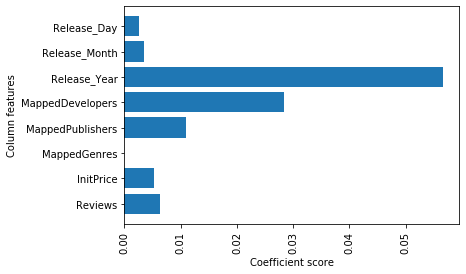


Analysis for : logreg
The best parameters for: logreg are :{'logreg__C': 0.8}
   mean_test_score              params
0         0.690083  {'logreg__C': 0.8}
1         0.690083    {'logreg__C': 1}
2         0.689050  {'logreg__C': 1.2}
3         0.690083  {'logreg__C': 1.4}
The score for logreg is 0.7148760330578512

Analysis for : knnstep
The best parameters for: knnstep are :{'knnstep__n_neighbors': 14}
    mean_test_score                        params
0          0.634298   {'knnstep__n_neighbors': 3}
1          0.664256   {'knnstep__n_neighbors': 4}
2          0.668388   {'knnstep__n_neighbors': 5}
3          0.664256   {'knnstep__n_neighbors': 6}
4          0.659091   {'knnstep__n_neighbors': 7}
5          0.664256   {'knnstep__n_neighbors': 8}
6          0.653926   {'knnstep__n_neighbors': 9}
7          0.671488  {'knnstep__n_neighbors': 10}
8          0.653926  {'knnstep__n_neighbors': 11}
9          0.664256  {'knnstep__n_neighbors': 12}
10         0.660124  {'knnstep__n_neighbor

In [171]:
df = ps4_game_list[['Reviews', 'InitPrice',
       'MappedGenres', 'MappedPublishers', 'MappedDevelopers',
                    'Release_Year', 'Release_Month', 'Release_Day',
       'Success']].copy()

sucrev_index = df[df['Reviews'].notna()].dropna().index
df = df[df['Reviews'].notna()].reset_index().drop(['index'],axis=1).dropna()

df.info()

df_all = df 

#df_all = pd.read_csv('../dat/cc_approvals_text.csv',na_values='?')
#df_all = df_all.drop(['Tweet'],axis=1)

x_train, x_test, y_train, y_test = preprocess_block(df_all, text_col=None, cat_var_limit=10, bin_rep=1,
                     max_tfidf_features=100, ngram_range=(1,2),
                     use_feat_select=True, 
                     alpha_space=np.linspace(0.01,0.02,20), 
                     random_state_var=20, test_size_var=.2)

_ = shallow_model(x_train, x_test, y_train, y_test)

_ = deep_model(x_train, x_test, y_train, y_test)

clf_shallow = load_model(clf='logreg')

clf_deep    = load_model('deep','Trained_deep_model.h5')

print(clf_shallow.predict(x_test))
print(clf_deep.predict(x_test))


In [233]:
df = ps4_game_list[['Reviews', 'InitPrice',
       'MappedGenres', 'MappedPublishers', 'MappedDevelopers',
                    'Release_Year', 'Release_Month', 'Release_Day',
       'Success']].copy()

val = clf_shallow.predict_proba(preprocess_df(df_all.drop('MappedGenres',axis=1).iloc[:,:-1], text_col=None, cat_var_limit=10, bin_rep=1))
pred_prob = np.where(val[:,0]>val[:,1],val[:,0],val[:,1])

pred = clf_shallow.predict(preprocess_df(df_all.drop('MappedGenres',axis=1).iloc[:,:-1], text_col=None, cat_var_limit=10, bin_rep=1))

sucrev_index = df[df['Reviews'].notna()].dropna().index
df = df[df['Reviews'].notna()].reset_index().drop(['index'],axis=1).dropna()

ps4_game_list['SuccessPredict'] = np.nan
ps4_game_list['SuccessPredict'] = pd.DataFrame(pred,index=sucrev_index,columns=['SuccessPredict'])

ps4_game_list['SuccessPredictProb'] = np.nan
ps4_game_list['SuccessPredictProb'] = pd.DataFrame(pred_prob,index=sucrev_index,columns=['SuccessPredictProb']).mul(100)

ps4_game_list['SuccessPredictText'] = ps4_game_list['SuccessPredict'].map({0.0:'Failure',1.0:'Success'})

ps4_game_list[['Reviews','SuccessPredict','SuccessPredictText','SuccessPredictProb']]

ps4_game_list[ps4_game_list['Reviews'].notna()].dropna().to_csv('ps4_game_list_predicted.csv')

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


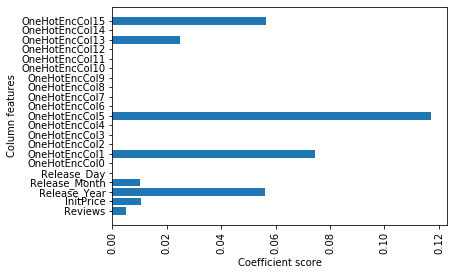

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


array([[7.700e+01, 2.999e+01, 2.018e+03, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       [7.900e+01, 1.499e+01, 2.014e+03, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       [7.900e+01, 1.999e+01, 2.017e+03, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       ...,
       [6.600e+01, 1.999e+01, 2.015e+03, ..., 0.000e+00, 0.000e+00,
        1.000e+00],
       [6.400e+01, 4.999e+01, 2.015e+03, ..., 0.000e+00, 1.000e+00,
        0.000e+00],
       [6.500e+01, 1.999e+01, 2.015e+03, ..., 0.000e+00, 0.000e+00,
        1.000e+00]])

In [25]:
dfa = df_all.copy()
dfb = dfa.drop('Game_comments',axis=1)

x_train, x_test, y_train, y_test = preprocess_block(dfb, text_col=None, cat_var_limit=10, bin_rep=0,
                     max_tfidf_features=10, ngram_range=(1,2),
                     use_feat_select=True, 
                     alpha_space=np.linspace(0.01,0.02,20), 
                     random_state_var=20, test_size_var=.3, load_preproc = None,
                     text_clean=False, pre_proc_filename = 'preproc.sav')

val1,_,_,_ = preprocess_block(dfb,load_preproc='preproc.sav')
val1

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def convert_cat_cols(df, cat_var_limit=10, verbose=False):                
    """
    Converts columns with a small amount of unique values that are of
    type Object into categorical variables.
    Number of unique values defined by cat_var_limit
    """
    cat_var_true = df.apply(lambda x: 
                            len(x.value_counts()) < cat_var_limit)
    object_type_true = df.apply(lambda x: 
                         x.value_counts().index.dtype == 'O')
    if cat_var_true[object_type_true].any():
        df[cat_var_true[object_type_true].index] = \
        df[cat_var_true[object_type_true].index].astype('category')
        if verbose:
            print(df[cat_var_true[object_type_true].index].describe())
    return df

def impute_most_freq(df):
    """
    Imputes the most frequent value in place of NaN's
    """
    most_freq = df.apply(lambda x: x.value_counts().index[0])
    return df.fillna(most_freq)

def convert_cat_labels(df, pre_proc_dict, preproc):
    """
    Converts columns with factors into integer representation
    """
    from sklearn.preprocessing import LabelEncoder
    if preproc is None:
        LEtransformer = {}
        for col in df.columns:
            LEtransformer[col] = LabelEncoder().fit(df[col])
            df[col] = LEtransformer[col].transform(df[col])
        pre_proc_dict['LabelEncode'] = LEtransformer
    else:
        LEtransformer = pre_proc_dict['LabelEncode']
        for col in df.columns:
            df[col] = LEtransformer[col].transform(df[col])     
    return df

def convert_cat_onehot(df, pre_proc_dict, preproc):
    """
    Converts columns with factors into integer representation
    """
    from sklearn.preprocessing import OneHotEncoder
    if preproc is None:
        OHtransformer = {}
        OHtransformer['col_list'] = df.columns
        OHtransformer['OHencode'] = OneHotEncoder().fit(df)
        temp_arr = OHtransformer['OHencode'].transform(df).toarray()
        for i in range(temp_arr.shape[1]):
            df['OneHotEncCol{}'.format(i)] = temp_arr[:,i]
            
        pre_proc_dict['OneHotEncode'] = OHtransformer
    else:
        OHtransformer = pre_proc_dict['OneHotEncode']
        temp_arr = OHtransformer['OHencode'].transform(df).toarray()
        for i in range(temp_arr.shape[1]):
            df['OneHotEncCol{}'.format(i)] = temp_arr[:,i]     
    return df

def clean_text(text_series):
    """
    Cleans a column of Tweets. Removes all special characters, 
    websites, mentions.
    """
    from re import sub as resub
    text_series = text_series.apply(
         lambda x:resub(
                r"[^A-Za-z0-9 ]+|(\w+:\/\/\S+)|htt", " ", x)
                     ).str.strip().str.lower()
    return text_series

def feat_select(df, pre_proc_dict, pre_proc_filename, text_mat=None, test_size_var=0.3, 
                alpha_space=np.linspace(0.01,0.02,20), 
                random_state_var=21, use_feat_select=True, plot=True):
    """
    Performs feature selection on a dataframe with a single target 
    variable and n features. Test train split is also performed and only 
    splits of selected features are returned. Feature selection performed 
    using LASSO weight shrinking.
    """
    from sklearn.model_selection import train_test_split
    from sklearn.model_selection import GridSearchCV
    from sklearn.linear_model import Lasso
    
    pre_proc_dict['feat_columns'] = df.columns[:-1]
    
    x_train, x_test, y_train, y_test = train_test_split(
        df.iloc[:,:-1], df.iloc[:,-1], test_size=test_size_var, 
        random_state=random_state_var, stratify=df.iloc[:,-1])

    if use_feat_select:
        param_grid = {'alpha': alpha_space}
        lasso_gcv = GridSearchCV(Lasso(normalize=False), param_grid, cv=5,
                                 n_jobs=-1, iid=True)
        lasso_coeffs = lasso_gcv.fit(x_train, y_train).best_estimator_.coef_
        if plot:
            plt.barh(y=range(len(df.columns[:-1])), width=np.abs(lasso_coeffs),
                     tick_label=df.columns[:-1].values)
            plt.ylabel('Column features')
            plt.xlabel('Coefficient score')
            plt.xticks(rotation=90)
            plt.show()
        try:
            select_feats = df.columns[:-1][np.abs(lasso_coeffs) > 0].values
            pre_proc_dict['feat_columns'] = select_feats
        except:
            print('Lasso Coefficients all turned out to be 0')
            print(' or could not be calculated. Check your')
            print(' dataset or switch off feature selection.')
                     
        x_train = x_train.loc[:,select_feats]
        x_test = x_test.loc[:,select_feats]
    
    if text_mat is not None:
        x_train = np.concatenate((x_train.values,text_mat[x_train.index,:]), axis=1)
        x_test = np.concatenate((x_test.values,text_mat[x_test.index,:]), axis=1)
    else:
        x_train = x_train.values
        x_test = x_test.values
    
    pickle.dump(pre_proc_dict, open(pre_proc_filename, 'wb'))
    return x_train, x_test, y_train.values, y_test.values


def preprocess_df(df_all, pre_proc_dict, preproc):

    text_col = pre_proc_dict['text_col']
    cat_var_limit = pre_proc_dict['cat_var_limit']
    bin_rep = pre_proc_dict['bin_rep']
    
    if text_col is not None:
        df = df_all.drop([text_col], axis=1).copy() #All columns except text
    else:
        df = df_all.copy()
    
    df = impute_most_freq(convert_cat_cols(df,cat_var_limit))
    
    cat_col_df = df.select_dtypes(include=['category'])
    cat_col_df_cols = cat_col_df.columns.copy()
    
    if not cat_col_df.empty:
        if bin_rep:
            df[cat_col_df.columns] = convert_cat_labels(cat_col_df, pre_proc_dict, preproc) 
            #Transforms a category variable column into an integer variable 
            #column
        else:
            temp_df = convert_cat_onehot(cat_col_df,pre_proc_dict, preproc) 
            temp_df = temp_df.drop(cat_col_df_cols, axis = 1)
            df = df.drop(cat_col_df_cols, axis = 1)
            df = pd.concat([pd.concat([df.iloc[:,:-1],temp_df],sort=False,axis=1),df.iloc[:,-1]],sort=False,axis=1)
            #Transforms a category variable column using OneHotEncoding
            
    assert (df.notnull().all().all()), 'Error: NaNs present in DataFrame, please clean data'
    assert df.select_dtypes(include=['object']).empty, 'Error: Some columns could not be converted to category valuables and encoded. Please segment non-numerical data columns (that is not the text column) or increase cat_var_limit'
    
    return df

def preprocess_df_text(df_all, pre_proc_dict, preproc):
    
    from sklearn.feature_extraction.text import TfidfVectorizer 
    
    text_col = pre_proc_dict['text_col']
    max_tfidf_features = pre_proc_dict['max_tfidf_features']
    ngram_range = pre_proc_dict['ngram_range']
    text_clean = pre_proc_dict['text_clean']
    text_fillna = pre_proc_dict['text_fillna']
    
    df_all[text_col] = df_all[text_col].fillna(text_fillna)
        
    if text_clean:
        try:
            df_all[text_col] = clean_text(df_all[text_col])
        except:
            print('Cannot clean text, recheck text column')
            
    if preproc is None:
        set_trace()
        pre_proc_dict['TfidVect'] = TfidfVectorizer(max_features=max_tfidf_features,
                                              ngram_range=ngram_range, 
                                              stop_words='english').fit(df_all[text_col])
        
        text_numeric_matrix = pre_proc_dict['TfidVect'].transform(df_all[text_col])
    else:
        text_numeric_matrix = pre_proc_dict['TfidVect'].transform(df_all[text_col])
    
    return text_numeric_matrix
    

def preprocess_block(df_orig, text_col=None, cat_var_limit=10, bin_rep=1,
                     max_tfidf_features=100, ngram_range=(1,2),
                     use_feat_select=True, 
                     alpha_space=np.linspace(0.01,0.02,20), 
                     random_state_var=20, test_size_var=.3, load_preproc = None,
                     text_fillna = 'No Text', text_clean=False, pre_proc_filename = 'preproc.sav'):
    """
    Preprocessing block: used to preprocess and transform the data columns
    ---------------------------------------------------------------------------
    -df_all (DataFrame): DataFrame with all the data, last column should be 
    target variable
    -text_col (str): name of the text column, default is None for no text columns
    -cat_var_limit (int): greatest number of unique values in a column to qualify 
    for conversion into a category column 
    -bin_rep (int): style of integer representation for category variables, 0 for 
    binary integer representation, 1 for 0 to nclass-1 representation
    -max_tfidf_features (int): maximum number of features after vectorizing text 
    column using tfidf metric
    -ngram_range (tuple): 2 tuple consisting of start and end point of ngram
    -use_feat_select (bool): True for applying feature selection using LASSO for 
    non-text columns
    -alpha_space (array of float): testing space for alpha parameter of LASSO
    -random_state_var (int): Random seed for train-test-split
    -test_size_var (float): ratio of test versus train split 
    -load_preproc
    ---------------------------------------------------------------------------
    """
    if load_preproc is None:
        pre_proc_dict = {}
        pre_proc_dict['text_col'] = text_col
        pre_proc_dict['max_tfidf_features'] = max_tfidf_features
        pre_proc_dict['ngram_range'] = ngram_range
        pre_proc_dict['cat_var_limit'] = cat_var_limit
        pre_proc_dict['bin_rep'] = bin_rep
        pre_proc_dict['text_clean'] = text_clean
        pre_proc_dict['text_fillna'] = text_fillna
        
    else:
        pre_proc_dict = pickle.load(open(load_preproc, 'rb'))
        text_col = pre_proc_dict['text_col']
        max_tfidf_features = pre_proc_dict['max_tfidf_features']
        ngram_range = pre_proc_dict['ngram_range']
        cat_var_limit = pre_proc_dict['cat_var_limit']
        bin_rep = pre_proc_dict['bin_rep']
        text_clean = pre_proc_dict['text_clean']
        text_fillna = pre_proc_dict['text_fillna']
        
    df_all = df_orig.copy()
    df = preprocess_df(df_all, pre_proc_dict, load_preproc)
    
    if load_preproc is None:
        if text_col is not None:
            text_numeric_matrix = preprocess_df_text(df_all, pre_proc_dict, load_preproc)
       
            return feat_select(df, pre_proc_dict, pre_proc_filename, text_numeric_matrix.toarray(), 
                           test_size_var=test_size_var, 
                           use_feat_select=use_feat_select, 
                           alpha_space=alpha_space, 
                           random_state_var=random_state_var, plot=True)
        else:
            return feat_select(df, pre_proc_dict, pre_proc_filename, use_feat_select=use_feat_select, 
                           test_size_var=test_size_var,
                           alpha_space=alpha_space, plot=True,
                           random_state_var=random_state_var)
    else:
        df = df[pre_proc_dict['feat_columns']]
        if text_col is not None:
            text_numeric_matrix = preprocess_df_text(df_all, pre_proc_dict, load_preproc)
            x_vals = np.concatenate((df.values,text_numeric_matrix.toarray()), axis=1) 
            return (x_vals, None, None, None)
        else:
            return (df.values, None, None, None)
        
    
def shallow_model(x_train, x_test, y_train, y_test, scaler_ch=0,
                  logreg_C=[0.8,1,1.2,1.4], knn_neigh=np.arange(3,16),
                  svc_c=[0.5,1,1.5,2,2.5,2.6], gb_max_depth=[2,3,4,5],
                  gb_n_est=[40,60,80,100], verbose=True, save=True,
                  model_file='Trained_shallow_models.sav'): 
    """
    This function will fit and test several shallow classfication models and 
    save them, models include:
    'logreg': Logistic Regression using the lbfgs solver
    'knnstep': K Nearest Neighbors
    'svcstep': Support Vector Classification model
    'gradbooststep': Gradient Boosted Classification Trees
    
    Scaling options include:
    MinMaxScaler between a range of -1 and 1
    Normalizer 
    StandardScaler
    
    The function will also run a 5 fold cross validated grid search for 
    hyperparameter optimization
    ---------------------------------------------------------------------------
    -x_train (DataFrame or ndarray): Training data consisting of features   
    -x_test (DataFrame or ndarray): Testing data consisting of features
    -y_train (DataFrame, Series or ndarray): Training data for predictions 
    (single class only)   
    -y_train (DataFrame, Series or ndarray): Testing data for predictions 
    (single class only)   
    -scaler_ch (int): Decides which scaler to use, 0 for MinMaxScaler, 1 for 
    Normalizer, 2 for StandarScaler
    -logreg_C (list of float): Hyperparameter space for C to be used in the 
    Log Reg Classifier
    -knn_neigh (list of int): Hyperparameter space for number of neighbors to 
    be used in the KNN Classifier
    -svc_c (list of float): Hyperparameter space for C to be used in the 
    Support Vector Classifier
    -gb_max_depth (list of int): Hyperparameter space for max depth to be used 
    in Gradient Boosted Classifier Trees
    -gb_n_est (list of int): Hyperparameter space for number of estimators to 
    be used in Gradient Boosted Classifier Trees
    -verbose (bool): Prints out details if True
    -save (bool): Switch for saving the trained models in an external data file
    -model_file (str): Filename for storing all the trained models
    ---------------------------------------------------------------------------
    """   
    from sklearn.preprocessing import MinMaxScaler
    from sklearn.preprocessing import Normalizer
    from sklearn.preprocessing import StandardScaler
    from sklearn.pipeline import Pipeline
    from sklearn.linear_model import LogisticRegression
    from sklearn.neighbors import KNeighborsClassifier
    from sklearn.ensemble import GradientBoostingClassifier
    from sklearn.model_selection import GridSearchCV
    from sklearn.svm import SVC
    import pickle
    
    scaler = [('Scaler', MinMaxScaler(feature_range=(-1, 1))),\
             ('Scaler', Normalizer()), ('Scaler', StandardScaler())]

    classifiers = [('logreg', LogisticRegression(solver='lbfgs', 
                                                 max_iter=1000)),\
        ('knnstep', KNeighborsClassifier()),\
        ('svcstep', SVC(gamma='scale')),\
         ('gradbooststep', GradientBoostingClassifier(subsample=.8))]

    parameters = {'logreg': {'logreg__C': logreg_C} ,\
              'knnstep': {'knnstep__n_neighbors': knn_neigh},\
              'svcstep': {'svcstep__C': svc_c},\
             'gradbooststep': {'gradbooststep__max_depth': gb_max_depth,\
                              'gradbooststep__n_estimators': \
                              gb_n_est}} 
    model_dict = {}

    for clf in classifiers:
        pipeline = Pipeline([scaler[scaler_ch], clf])
        print('\nAnalysis for : ' + clf[0])
        gcv = GridSearchCV(pipeline, param_grid=parameters[clf[0]],
                           cv=5, iid=True)
        gcv.fit(x_train, y_train)
        model_dict[clf[0]] = (gcv, gcv.score(x_test, y_test))
        if verbose:
            print('The best parameters for: ' + clf[0] + ' are :' +
                  str(gcv.best_params_))
            print(pd.DataFrame(gcv.cv_results_)
                  [['mean_test_score','params']])
        print('The score for ' + clf[0] + ' is ' + 
              str(gcv.score(x_test, y_test))) 
    
    if save:
        pickle.dump(model_dict, open(model_file, 'wb'))
    
    return model_dict


def deep_model(x_train, x_test, y_train, y_test, scaler_ch=0, 
               patience_val=2, validation_split_val=.2, epochs_val=20,
               verbose=True, save=True, model_file='Trained_deep_model.h5'):
    """
    This function will fit and test a Deep Neural Network that uses ReLu 
    and softmax activation functions. It also uses an EarlyStopper
    
    Scaling options include:
    MinMaxScaler between a range of -1 and 1
    Normalizer 
    StandardScaler
    
    ---------------------------------------------------------------------
    -x_train (DataFrame or ndarray): Training data consisting of features   
    -x_test (DataFrame or ndarray): Testing data consisting of features
    -y_train (DataFrame, Series or ndarray): Training data for predictions 
    (single class only)   
    -y_train (DataFrame, Series or ndarray): Testing data for predictions 
    (single class only)    
    -scaler_ch (int): Decides which scaler to use, 0 for MinMaxScaler, 
    1 for Normalizer, 2 for StandarScaler
    -patience_val (int): Number of epochs to monitor before exiting 
    training if no major changes in accuracy occurs
    -validation_split_val (float): ratio of split of dataset for testing 
    purposes
    -epochs_val (int): Max number of epochs to train
    -verbose (bool): Model training details will be printed out if True
    -save (bool): Switch for saving the trained models in an external data 
    file
    -model_file (str): Filename for storing the trained model. Must be H5 
    extension
    ----------------------------------------------------------------------
    """   
    from sklearn.preprocessing import MinMaxScaler
    from sklearn.preprocessing import Normalizer
    from sklearn.preprocessing import StandardScaler
    from keras.layers import Dense
    from keras.models import Sequential
    from keras.callbacks import EarlyStopping
    
    scaler_list = [('Scaler', MinMaxScaler(feature_range=(-1, 1))),\
              ('Scaler', Normalizer()),\
              ('Scaler', StandardScaler())]

    scaler = scaler_list[scaler_ch][1]
    
    x_train = scaler.fit_transform(x_train)
    x_test = scaler.fit_transform(x_test)

    n_cols = x_train.shape[-1]

    model = Sequential()
    model.add(Dense(5, activation='relu', input_shape=(n_cols,)))
    model.add(Dense(10, activation='relu'))
    model.add(Dense(15, activation='relu'))
    model.add(Dense(20, activation='relu'))
    model.add(Dense(15, activation='relu'))
    model.add(Dense(10, activation='relu'))
    model.add(Dense(2,activation='softmax'))

    early_stop_monitor = EarlyStopping(patience=patience_val)
    model.compile (optimizer='adam',
                   loss= 'categorical_crossentropy',
                   metrics=['accuracy'])
    train_dp_model=model.fit(x_train, pd.get_dummies(y_train).values,
                             validation_split=validation_split_val, 
                             epochs = epochs_val,
                             callbacks =[early_stop_monitor],
                             verbose=verbose)

    print('Loss metrics: ' + str(train_dp_model.history['loss'][-1]))
    
    pred_prob = model.predict(x_test)
    accuracy_dp = np.sum((pred_prob[:,1]>=0.5)==y_test) / len(y_test)
    print('DNN Testing accuracy: ' + str(accuracy_dp)) 
    
    if save:
        model.save(model_file)   
    
    return model


def load_model(type='shallow', filename='Trained_shallow_models.sav', 
               clf='logreg'):
    """
    This function is used to load a previously saved trained model. 
    The model will have been saved in an external file.
    
    ---------------------------------------------------------------------
    -type (str): 'shallow' to load a trained shallow model, 
    'deep' to load a trained deep model
    -filename (str): Name of the file with the saved model
    -clf (str): Only used for retrieving shallow models, this is the label 
    of the classifier -
    'logreg': Logistic Regression using the lbfgs solver
    'knnstep': K Nearest Neighbors
    'svcstep': Support Vector Classification model
    'gradbooststep': Gradient Boosted Classification Trees
    ---------------------------------------------------------------------
    """
    assert (type == 'shallow' or type == 'deep'), 'Wrong input for type' 
    if type == 'shallow':
        import pickle
        try:
            model_dict = pickle.load(open(filename, 'rb'))
        except:
            print('Could not load file. Check filename.')
        for label, model in model_dict.items():
            print(label + ' score is: ' + str(model[1]))
        return model_dict[clf][0]
    
    elif type == 'deep':
        from keras.models import load_model 
        try:
            model = load_model(filename)
        except:
            print('Could not load file. Check filename.')
        print('Model Summary: ')
        model.summary()
        return model

In [ ]:
#######3 DO NOT RUN

jhsfjkdsfad = hjadsfld

xpath_0_m = '/html/body/div[3]/div[3]/div[4]/div/table[2]//tr[{}]//text()'
html_add_0_m = 'https://en.wikipedia.org/wiki/List_of_PlayStation_4_games'

xpath_m_z = '/html/body/div[3]/div[3]/div[4]/div/table/tbody/tr[{}]//text()'
html_add_m_z = 'https://en.wikipedia.org/wiki/List_of_PlayStation_4_games_(M-Z)'

ps4_game_list = get_wiki_table_df(    
    get_wiki_table_list(html_add_m_z, xpath_m_z, 3, get_wiki_table_list(html_add_0_m, xpath_0_m, 3)))

ps4_game_pricehist_dict = {}
ps4_game_pricehist_dict = get_all_price_histsandrev(ps4_game_list)
pickle.dump(ps4_game_pricehist_dict, open('pricehist_pkl.sav', 'wb'))

get_prepdf_withreg(ps4_game_list, ps4_game_pricehist_dict, days = None, 
                       publisher_medval = 18, publisher_lowval = 3,
                      dev_medval = 4, dev_lowval = 1, genre_map = 'genre.csv')

get_successcol(ps4_game_list,threshold = -0.0003, verbose=True)

ps4_game_list.to_csv('ps4_game_list.csv')

prepdf_for_comments(ps4_game_list,comment_window = 30)
df = ps4_game_list[ps4_game_list['Reviews'].notna()].dropna().reset_index().drop(['index'],axis=1)

psaw_api = create_psaw_instance(create_reddit_instance(filename = 'RedditAuth'))
get_reddit_comments(df,psaw_api,max_response_cache = 100)

df.to_csv('ps4_game_list_withrevsandtext.csv')

df_all = df[['Reviews', 'InitPrice',
       'MappedGenres', 'MappedPublishers', 'MappedDevelopers',
                    'Release_Year', 'Release_Month', 'Release_Day',
       'Game_comments','Success']]

x_train, x_test, y_train, y_test = preprocess_block(df_all, text_col='Game_comments', cat_var_limit=10, bin_rep=0,
                     max_tfidf_features=10, ngram_range=(1,2),
                     use_feat_select=True, 
                     alpha_space=np.linspace(0.01,0.02,20), 
                     random_state_var=20, test_size_var=.3,text_fillna = 'No Text', load_preproc = None,
                     text_clean=False, pre_proc_filename = 'preproc.sav')


_ = shallow_model(x_train, x_test, y_train, y_test)

#_ = deep_model(x_train, x_test, y_train, y_test)

clf_shallow = load_model(clf='logreg')

#clf_deep    = load_model('deep','Trained_deep_model.h5')

testing_vals,_,_,_ = preprocess_block(df_all, load_preproc='preproc.sav')

#pred_deep = clf_deep.predict(testing_vals)

val = clf_shallow.predict_proba(testing_vals)
pred_prob = np.where(val[:,0]>val[:,1],val[:,0],val[:,1])
pred = np.where(val[:,0]>val[:,1],0,1)

df['SuccessPredict'] = np.nan
df['SuccessPredict'] = pd.DataFrame(pred,index=df.index,columns=['SuccessPredict'])

df['SuccessPredictProb'] = np.nan
df['SuccessPredictProb'] = pd.DataFrame(pred_prob,index=df.index,columns=['SuccessPredictProb']).mul(100)

df['SuccessPredictText'] = df['SuccessPredict'].map({0:'Failure',1:'Success'})


